In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

In [3]:
xr.__version__

'0.12.3'

In [4]:
import sys
a2emmc_path = '/home/equon/a2e-mmc'
if not a2emmc_path in sys.path:
    sys.path.append(a2emmc_path)

In [5]:
from mmctools.wrf.ts import read_tslist, TowerArray
from mmctools.plotting import plot_timeheight, plot_timehistory_at_height

# Process tslist output
Notes:
- `TS` is a surface time series
- `PH` is elevation (instead of perturbation geopotential)
- `UU`, `VV`, `WW` are velocities [m/s]
- `PR` is (assumed) to be pressure [Pa]

In [6]:
# WRF inputs
wrfcasedir = '/Users/equon/MMC/SWIFTRegion/SWIFT_2013110800_GFS'
#wrfcasedir = '/projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS'

# from namelist.input:
domain = 3
Nlevels = 88 # `max_ts_level` 
Nlat,Nlon = 11,11
starttime = '2013-11-08 00:00' # `start_*`
dt = 10.0 # time step (and output frequency) [s]

In [7]:
outdir = '/Users/equon/MMC/SWIFTRegion/wrf_to_sowfa/data'
#outdir = '/projects/mmc/equon/SWIFTRegion/wrf_to_sowfa/data'

In [8]:
# constant heights to interpolate data to
spacing = 10. # microscale grid [m]
heights = np.arange(0,2000+spacing,spacing)

In [9]:
# TTU tower
TTU_latlon = (33.61056, -102.05056)

## create TowerArray object

In [10]:
towers = TowerArray(outdir, wrfcasedir, domain, starttime,
                    tslistpath=os.path.join(wrfcasedir,'tslist'),
                    snap_to_grid=(Nlat,Nlon), grid_order='F',
                    convert_to_xy='utm', latlon_ref=TTU_latlon)
#towers.load_data()

Attemping to adjust grid lat/lon
  lat/lon spacings: 0.02698181818181802 0.03240000000000007
  shifting lat/lon grid by (6.94215e-05, -0.000231405)


In [11]:
towers.tslist.head()

,name,lat,lon,x,y
prefix,,,,,
t0001,tower0001,33.475569,-102.212531,-14630.127998,-15390.282475
t0002,tower0002,33.502551,-102.212531,-14710.532596,-12397.444843
t0003,tower0003,33.529533,-102.212531,-14790.994683,-9404.597245
t0004,tower0004,33.556515,-102.212531,-14871.514242,-6411.739677
t0005,tower0005,33.583497,-102.212531,-14952.091254,-3418.872133


## combine dataset
<font color='red'>Note that this may be *very* memory intensive</font>

In [12]:
ds = towers.load_combined_data(os.path.join(outdir,'alltowers.nc'), chunks={'lat':1,'lon':1})

## get coordinates

In [13]:
# easy part
lat,lon = np.meshgrid(ds.coords['lat'], ds.coords['lon'], indexing='ij')

In [14]:
# SANITY CHECK:
# lat,lon grid created from dataset coordinates (with ij indexing) agrees with sliced data
# i.e., the sliced data also have ij indexing
testvals = ds.sel(datetime='2013-11-08 12:00:00',height=80.)
for i in range(Nlat):
    for j in range(Nlon):
        #print(i,j)
        selected = testvals.isel({'lat':i,'lon':j})
        assert selected.coords['lat'] == lat[i,j]
        assert selected.coords['lon'] == lon[i,j]

In [15]:
# now, reorder the tslist get the UTM coordinates
tslist = towers.tslist.reset_index().set_index(['lat','lon']).sort_index()

In [16]:
# adjust multiindices in case there is a slight mismatch
# - the order of the multiindex levels should match the unique lat/lon grid values
# - the index values should be very nearly identical
tol = 1e-12
for i,latval in enumerate(lat[:,0]):
    curidx = tslist.index.levels[0].get_loc(latval, method='nearest')
    assert curidx == i
    origval = tslist.index.levels[0][i]
    err = np.abs(origval - latval)
    assert err < tol
for j,lonval in enumerate(lon[0,:]):
    curidx = tslist.index.levels[1].get_loc(lonval, method='nearest')
    assert curidx == j
    origval = tslist.index.levels[1][j]
    err = np.abs(origval - lonval)
    assert err < tol

In [17]:
# adjust levels with expected values so that we can call MultiIndex.get_locs()
tslist.index.set_levels(lat[:,0], level='lat', inplace=True)
tslist.index.set_levels(lon[0,:], level='lon', inplace=True)

In [18]:
# reorder tslist
locs = tslist.index.get_locs([lat.ravel(), lon.ravel()])
tslist = tslist.iloc[locs]
tslist.head()

prefix       name             x             y
lat       lon                                                      
33.475569 -102.212531  t0001  tower0001 -14630.127998 -15390.282475
          -102.180131  t0012  tower0012 -11618.374873 -15308.927661
          -102.147731  t0023  tower0023  -8606.588719 -15226.630242
          -102.115331  t0034  tower0034  -5594.769156 -15143.390132
          -102.082931  t0045  tower0045  -2582.915806 -15059.207247

In [19]:
# now we can get the x,y grid
x = np.reshape(tslist['x'].values, lat.shape)
y = np.reshape(tslist['y'].values, lat.shape)

## check some data

In [20]:
uhub = ds['u'].sel(height=80.0)
vhub = ds['v'].sel(height=80.0)
whub = ds['w'].sel(height=80.0)
phub = ds['pr'].sel(height=80.0)
uhub

<xarray.DataArray 'u' (datetime: 21600, lat: 11, lon: 11)>
dask.array<shape=(21600, 11, 11), dtype=float64, chunksize=(21600, 1, 1)>
Coordinates:
  * datetime  (datetime) datetime64[ns] 2013-11-08T00:00:10 ... 2013-11-10T12:00:00
    height    float64 80.0
  * lat       (lat) float64 33.48 33.5 33.53 33.56 ... 33.66 33.69 33.72 33.75
  * lon       (lon) float64 -102.2 -102.2 -102.1 -102.1 ... -102.0 -101.9 -101.9

In [21]:
uhub.sel(datetime='2013-11-08 12:00:00')

<xarray.DataArray 'u' (lat: 11, lon: 11)>
dask.array<shape=(11, 11), dtype=float64, chunksize=(1, 1)>
Coordinates:
    datetime  datetime64[ns] 2013-11-08T12:00:00
    height    float64 80.0
  * lat       (lat) float64 33.48 33.5 33.53 33.56 ... 33.66 33.69 33.72 33.75
  * lon       (lon) float64 -102.2 -102.2 -102.1 -102.1 ... -102.0 -101.9 -101.9

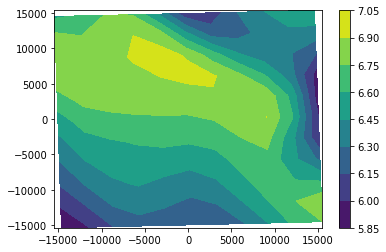

In [22]:
uhubsel = uhub.sel(datetime='2013-11-08 12:00:00')
cont = plt.contourf(x,y,uhubsel.values)
plt.colorbar(cont)

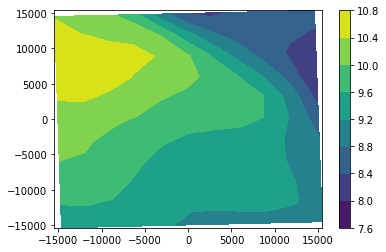

In [23]:
vhubsel = vhub.sel(datetime='2013-11-08 12:00:00')
cont = plt.contourf(x,y,vhubsel.values)
plt.colorbar(cont)

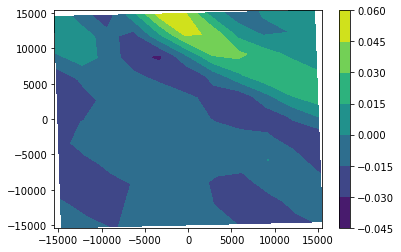

In [24]:
whubsel = whub.sel(datetime='2013-11-08 12:00:00')
cont = plt.contourf(x,y,whubsel.values)
plt.colorbar(cont)

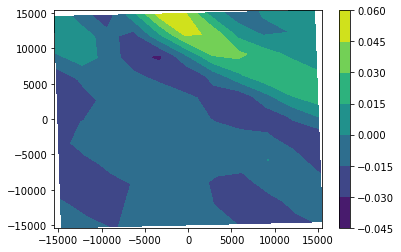

In [25]:
phubsel = whub.sel(datetime='2013-11-08 12:00:00')
cont = plt.contourf(x,y,phubsel.values)
plt.colorbar(cont)

## calculate pressure gradient near TTU tower
<font color='red'>TODO: Use Dries' processing/averaging tools</font>

In [26]:
i0 = np.argmin(np.abs(TTU_latlon[0] - lat[:,0]))
j0 = np.argmin(np.abs(TTU_latlon[1] - lon[0,:]))
print(TTU_latlon)
print(lat[i0,j0], lon[i0,j0])

(33.61056, -102.05056)
33.610478512396696 -102.05053140495866


In [27]:
# y-gradient from diff in latitudinal dimension
dy = y[i0+1,j0] - y[i0-1,j0]
print('dy=',dy)
dp = ds['pr'].isel({'lat':i0+1,'lon':j0}) - ds['pr'].isel({'lat':i0-1,'lon':j0})
dpdy = dp/dy
dpdy = dpdy.to_dataframe()['pr']

dy= 5986.095200000331


In [28]:
# x-gradient from diff in longitudinal dimension
dx = x[i0,j0+1] - x[i0,j0-1]
print('dx=',dx)
dp = ds['pr'].isel({'lat':i0,'lon':j0+1}) - ds['pr'].isel({'lat':i0,'lon':j0-1})
dpdx = dp/dx
dpdx = dpdx.to_dataframe()['pr']

dx= 6014.422573660966


In [29]:
dpdx_10min = dpdx.unstack(level='height').rolling('10min').mean().stack()
dpdy_10min = dpdy.unstack(level='height').rolling('10min').mean().stack()

In [30]:
gradp = pd.concat([dpdx_10min, dpdy_10min], axis=1)
gradp.columns = ['dpdx', 'dpdy']

## plots

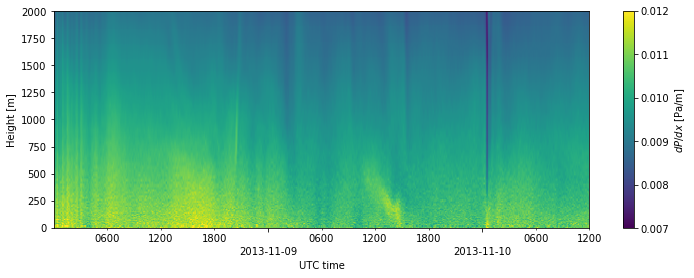

In [32]:
fig,ax,cbar = plot_timeheight(dpdx_10min,
                              fieldlabels=r'$dP/dx$ [Pa/m]',
                              fieldlimits=(0.007,0.012))

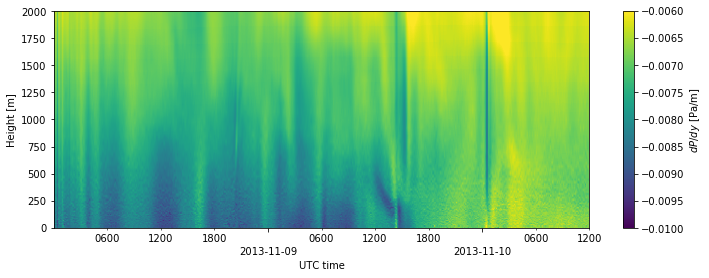

In [33]:
fig,ax,cbar = plot_timeheight(dpdy_10min,
                              fieldlabels=r'$dP/dy$ [Pa/m]',
                              fieldlimits=(-0.010,-0.006))

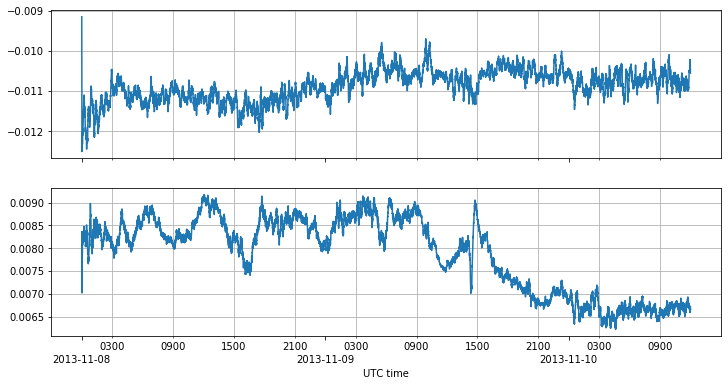

In [34]:
selected_height = 80.

fig,ax = plot_timehistory_at_height(-gradp,
                                    fields=['dpdx','dpdy'],
                                    heights=selected_height,
                                   )
